Neural data analysis: 

_Neural Data Analysis_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Sarah Strauss, Ziwei Huang

Summer term 2021

Student names: *Harry Antony (5610172) | Nishad Singhi (5619175)*

# Coding Lab 9: Transcriptomics

In [1]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns
import pandas as pd
import pickle
import scipy
from scipy import sparse

# I recommend using openTSNE for experiments with t-SNE
# https://github.com/pavlin-policar/openTSNE
# conda install -c conda-forge openTSNE 
from openTSNE import TSNE

In [3]:
# LOAD HARRIS ET AL DATA

# Load gene counts
data = pd.read_csv('harris-data/expression.tsv.gz', sep='\t')
genes = data.values[:,0]
cells = data.columns[1:-1]
counts = data.values[:,1:-1].transpose().astype('int')
data = []

# Kick out all genes with all counts = 0
genes = genes[counts.sum(axis=0)>0]
counts = counts[:, counts.sum(axis=0)>0]
print(counts.shape)

# Load clustering results
data = pd.read_csv('harris-data/analysis_results.tsv', sep='\t')
clusterNames, clusters = np.unique(data.values[0,1:-1], return_inverse=True)

# Load cluster colors
data = pd.read_csv('harris-data/colormap.txt', sep='\s+', header=None)
clusterColors = data.values

# Note: the color order needs to be reversed to match the publication
clusterColors = clusterColors[::-1]

# Taken from Figure 1 - we need cluster order to get correct color order
clusterOrder = ['Sst.No', 'Sst.Npy.C', 'Sst.Npy.Z', 'Sst.Npy.S', 'Sst.Npy.M',
                'Sst.Pnoc.Calb1.I', 'Sst.Pnoc.Calb1.P', 'Sst.Pnoc.P', 'Sst.Erbb4.R',
                'Sst.Erbb4.C', 'Sst.Erbb4.T', 'Pvalb.Tac1.N', 'Pvalb.Tac1.Ss',
                'Pvalb.Tac1.Sy', 'Pvalb.Tac1.A', 'Pvalb.C1ql1.P', 'Pvalb.C1ql1.C',
                'Pvalb.C1ql1.N', 'Cacna2d1.Lhx6.R', 'Cacna2d1.Lhx6.V', 'Cacna2d1.Ndnf.N',
                'Cacna2d1.Ndnf.R', 'Cacna2d1.Ndnf.C', 'Calb2.Cry', 'Sst.Cry', 'Ntng1.S',
                'Ntng1.R', 'Ntng1.C', 'Cck.Sema', 'Cck.Lmo1.N', 'Cck.Calca', 'Cck.Lmo1.Vip.F',
                'Cck.Lmo1.Vip.C', 'Cck.Lmo1.Vip.T', 'Cck.Ly', 'Cck.Cxcl14.Calb1.Tn',
                'Cck.Cxcl14.Calb1.I', 'Cck.Cxcl14.S', 'Cck.Cxcl14.Calb1.K',
                'Cck.Cxcl14.Calb1.Ta', 'Cck.Cxcl14.V', 'Vip.Crh.P', 'Vip.Crh.C1', 'Calb2.Vip.G',
                'Calb2.Vip.I', 'Calb2.Vip.Nos1', 'Calb2.Cntnap5a.R', 'Calb2.Cntnap5a.V',
                'Calb2.Cntnap5a.I']

reorder = np.zeros(clusterNames.size) * np.nan
for i,c in enumerate(clusterNames):
    for j,k in enumerate(clusterOrder):
        if c[:len(k)]==k:
            reorder[i] = j
            break
clusterColors = clusterColors[reorder.astype(int)]

(3663, 17965)


## 1. Data inspection
Before we do tSNE visualisation or other advanced methods on the data, we first want to have a closer look on the data and plot some statistics. For most of the analysis we will compare the data to a Poisson distribution.

###  1.1. Relationship between expression mean and fraction of zeros
The higher the average expression of a gene, the smaller fraction of cells will show a 0 count. 


_(2pts.)_

In [7]:
# Compute the average expression for each gene
# Compute the fraction of zeros for each gene

expression_mean = np.mean(counts, axis=0)
zero_fraction   = np.array([np.mean(counts[:, i] == 0) for i in range(counts.shape[1])])

In [8]:
# Compute the Poisson prediction 
# (what is the expected fraction of zeros in a Poisson distribution with a given mean?)
poisson_pred = np.exp(-expression_mean)

<IPython.core.display.Javascript object>


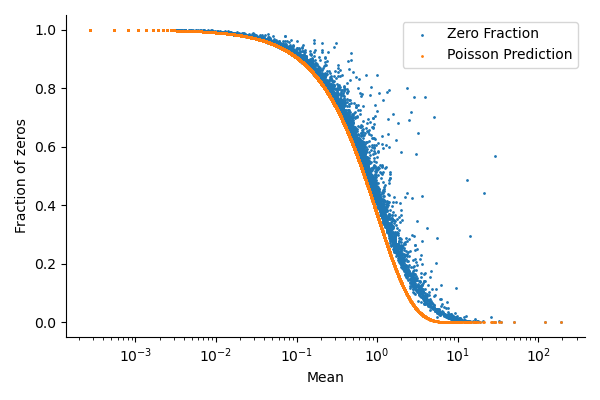

In [38]:
# plot the data and the Poisson prediction

plt.figure(figsize=(6,4))

plt.xscale('log')
plt.xlabel('Mean')
plt.ylabel('Fraction of zeros')

plt.scatter(expression_mean, zero_fraction, label='Zero Fraction', s=1)
plt.scatter(expression_mean, poisson_pred, label='Poisson Prediction', s=1)
plt.legend()

sns.despine()
plt.tight_layout()

### 1.2. Mean-variance relationship

If the expression follows Poisson distribution, then the mean should be equal to the variance.

_(1pt.)_

In [14]:
# Compute the variance of the expression counts of each gene
expression_var = np.var(counts, axis=0)

<IPython.core.display.Javascript object>


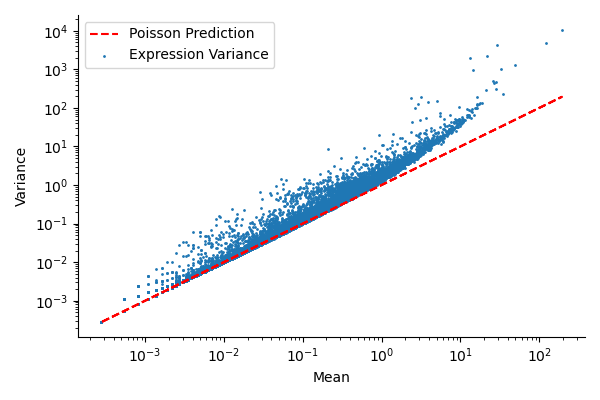

In [36]:
# Plot the mean-variance relationship on a log-log plot
# Plot the Poisson prediction as a line

plt.figure(figsize=(6,4))

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mean')
plt.ylabel('Variance')


plt.scatter(expression_mean, expression_var, label='Expression Variance', s=1)
plt.plot(expression_mean, expression_mean, label='Poisson Prediction', color='red', linestyle='--')
plt.legend()

sns.despine()
plt.tight_layout()

### 1.3. Relationship between the mean and the Fano factor

If the expression follows the Poisson distribution, then the Fano factor (variance/mean) should be equal to 1 for all genes.

_(1pt.)_

<IPython.core.display.Javascript object>


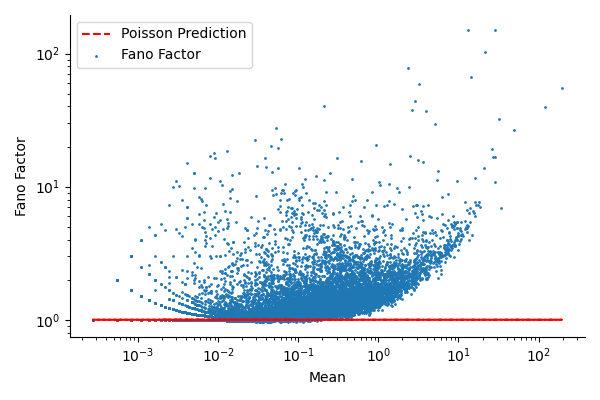

In [37]:
# Compute the Fano factor for each gene and make a scatter plot 
# of expression mean vs. Fano factor in log-log coordinates.
# Plot a Poisson prediction as line

# Use the same style of plot as above.
plt.figure(figsize=(6,4))

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mean')
plt.ylabel('Fano Factor')


plt.scatter(expression_mean, expression_var/expression_mean, label='Fano Factor', s=1)
plt.plot(expression_mean, expression_mean/expression_mean, label='Poisson Prediction', color='red', linestyle='--')
plt.legend()

sns.despine()
plt.tight_layout()




### 1.4. Histogram of sequencing depths

Different cells have different sequencing depths (sum of counts across all genes) because the efficiency can change from droplet to droplet due to some random experimental factors.

_(1pt.)_

<IPython.core.display.Javascript object>


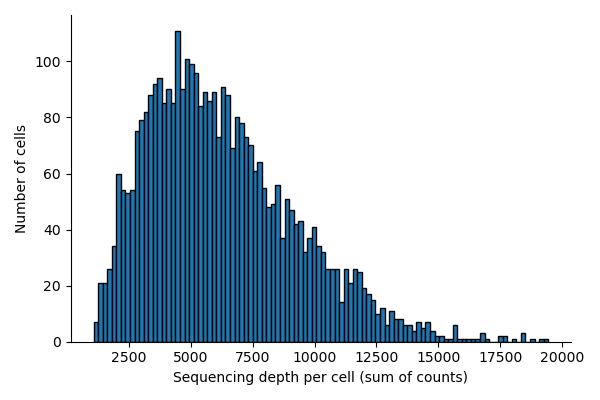

In [33]:
# Make a histogram of sequencing depths across cells.
# Sequencing depth of each cell is the sum of all counts of this cell

plt.figure(figsize=(6,4))

seq_depth = np.sum(counts, axis=1)

plt.xlabel('Sequencing depth per cell (sum of counts)')
plt.ylabel('Number of cells')

plt.hist(seq_depth, edgecolor='k', bins=100)

sns.despine()
plt.tight_layout()

### 1.5. Fano factors after normalization

After normalization by sequencing depth, Fano factor should be closer to 1 (i.e. variance even more closely following the mean). This can be used for feature selection.

_(1pt.)_

<IPython.core.display.Javascript object>


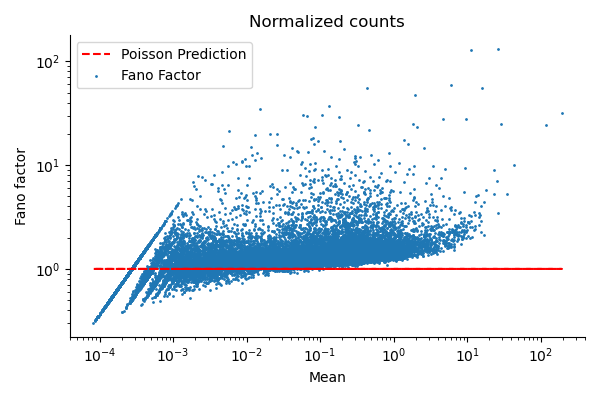

In [40]:
# Normalize counts by the sequencing depth of each cell and multiply by the median sequencing depth
# Then make the same expression vs Fano factor plot as above
median_seq_depth = np.median(seq_depth)
normalized_counts = median_seq_depth*counts/seq_depth.reshape(-1, 1)

expression_mean_normalized = np.mean(normalized_counts, axis=0)
expression_var_normalized = np.var(normalized_counts, axis=0)
fano_factor_normalized = expression_var_normalized/expression_mean_normalized


plt.figure(figsize=(6,4))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mean')
plt.ylabel('Fano factor')
plt.title('Normalized counts')

plt.scatter(expression_mean_normalized, fano_factor_normalized, s=1, label='Fano Factor')
plt.plot(expression_mean_normalized, expression_mean_normalized/expression_mean_normalized, color='red', linestyle='--', label='Poisson Prediction')
plt.legend()

sns.despine()
plt.tight_layout()

In [43]:
# Find top-10 genes with the highest normalized Fano factor
# Print them sorted by the Fano factor starting from the highest
# Gene names are stored in the `genes` array
top_genes = genes[np.argsort(fano_factor_normalized)[::-1][:10]]
print(top_genes)

['Sst' 'Npy' 'Vip' 'Cck' 'Cpne2' 'Pcp4' 'Ptpn23' 'Pdzd9' 'Malat1' 'Armc2']


## 2. Low dimensional visualization

Here we look at the influence of variance-stabilizing transformations on PCA and t-SNE.

### 2.1. PCA with and without transformations

Square root is a variance-stabilizing transformation for the Poisson data. Log-transform is also often used in the transcriptomic community. Look at the effect of both.

_(1pt.)_

In [50]:
# Transform the counts into normalized counts (as above)
# (Normalize counts by the sequencing depth of each cell and multiply by the median sequencing depth)
# Select all genes with the normalized Fano factor above 3 and remove the rest

selected_counts = counts[:, fano_factor_normalized > 3]

In [67]:
# Perform PCA three times: on the resulting matrix as is, 
# after np.log2(X+1) transform, and after np.sqrt(X) transform

from sklearn.decomposition import PCA

pca1 = PCA(50).fit(selected_counts).transform(selected_counts)
pca2 = PCA(50).fit(np.log2(selected_counts+1)).transform(np.log2(selected_counts+1))
pca3 = PCA(50).fit(np.sqrt(selected_counts)).transform(np.sqrt(selected_counts))

<IPython.core.display.Javascript object>


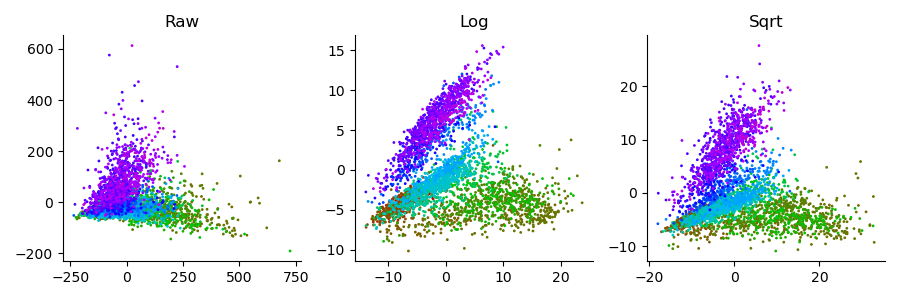

In [68]:
# Plot the results

plt.figure(figsize=(9,3))

plt.subplot(131)
plt.scatter(pca1[:,0], pca1[:,1], s=1, c=clusterColors[clusters])
plt.title('Raw')

plt.subplot(132)
plt.scatter(pca2[:,0], pca2[:,1], s=1, c=clusterColors[clusters])
plt.title('Log')

plt.subplot(133)
plt.scatter(pca3[:,0], pca3[:,1], s=1, c=clusterColors[clusters])
plt.title('Sqrt')

sns.despine()
plt.tight_layout()

### 2.2. tSNE with and without transformations

Do these transformations have any effect on t-SNE?

_(1pt.)_

In [79]:
# Perform tSNE three times: on the resulting matrix as is, 
# after np.log2(X+1) transform, and after np.sqrt(X) transform

# Apply t-SNE to the 50 PCs

# Use default settings of openTSNE
# You can also use sklearn if you want

from sklearn.manifold import TSNE

# tsne = TSNE()

tsne1 = TSNE().fit_transform(pca1)#.transform(pca1)
tsne2 = TSNE().fit_transform(pca2)
tsne3 = TSNE().fit_transform(pca3)
# tsne2 = tsne.fit(pca2).transform(pca2)
# tsne3 = tsne.fit(pca3).transform(pca3)

<IPython.core.display.Javascript object>


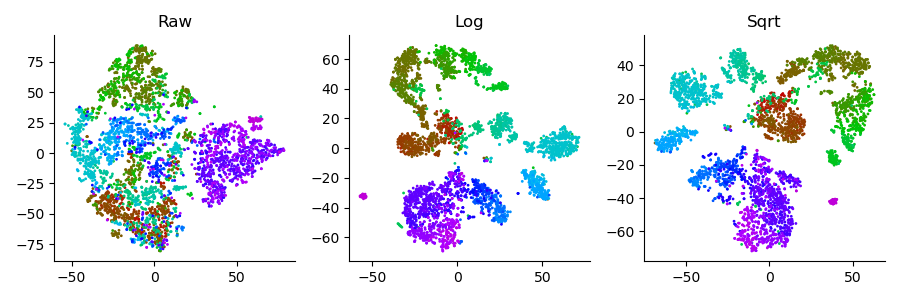

In [80]:
# Plot the results

plt.figure(figsize=(9,3))

plt.subplot(131)
plt.scatter(tsne1[:,0], tsne1[:,1], s=1, c=clusterColors[clusters])
plt.title('Raw')

plt.subplot(132)
plt.scatter(tsne2[:,0], tsne2[:,1], s=1, c=clusterColors[clusters])
plt.title('Log')

plt.subplot(133)
plt.scatter(tsne3[:,0], tsne3[:,1], s=1, c=clusterColors[clusters])
plt.title('Sqrt')

sns.despine()
plt.tight_layout()

### 2.3. Leiden clustering

This dataset is small and can be clustered in many different ways. We will apply Leiden clustering (closely related to the Louvain clustering), which is standard in the field and works well even for very large datasets.

_(1pt.)_

In [85]:
# To run this code you need to install leidenalg and igraph
# conda install -c conda-forge python-igraph leidenalg

import igraph as ig
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
import leidenalg as la

In [86]:
# Define some contrast colors

clusterCols = ["#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
        "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
        "#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
        "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
        "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
        "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
        "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
        "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
        "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
        "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
        "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
        "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
        "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C",
        "#83AB58", "#001C1E", "#D1F7CE", "#004B28", "#C8D0F6", "#A3A489", "#806C66", "#222800",
        "#BF5650", "#E83000", "#66796D", "#DA007C", "#FF1A59", "#8ADBB4", "#1E0200", "#5B4E51",
        "#C895C5", "#320033", "#FF6832", "#66E1D3", "#CFCDAC", "#D0AC94", "#7ED379", "#012C58"]
clusterCols = np.array(clusterCols)

# Construct kNN graph with k=15

A = kneighbors_graph(pca3, 15)

# Transform it into an igraph object

sources, targets = A.nonzero()
G = ig.Graph(directed=False)
G.add_vertices(A.shape[0])
edges = list(zip(sources, targets))
G.add_edges(edges)

In [87]:
# Run Leiden clustering 

partition = la.find_partition(G, la.RBConfigurationVertexPartition, resolution_parameter=1, seed=42)

<IPython.core.display.Javascript object>


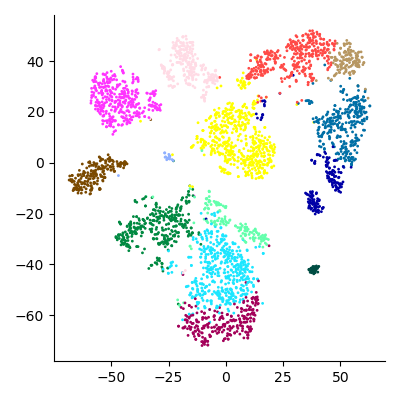

In [88]:
# Plot the results

plt.figure(figsize=(4,4))
plt.scatter(tsne3[:,0], tsne3[:,1], s=1, c=clusterCols[partition.membership])

sns.despine()
plt.tight_layout()

### 2.4. Change the clustering resolution

The number of clusters can be changed by modifying the resolution parameter.

_(1pt.)_

In [ ]:
# How many clusters did we get?
# Change the resolution parameter to yield 2x more and 2x fewer clusters
# Plot all three results as tSNE overlays (as above)


In [91]:
#print(np.max(partition.membership))

partition2 = la.find_partition(G, la.RBConfigurationVertexPartition, resolution_parameter=0.5, seed=42)
print(np.max(partition2.membership))

partition3 = la.find_partition(G, la.RBConfigurationVertexPartition, resolution_parameter=2, seed=42)
print(np.max(partition3.membership))


9
21


<IPython.core.display.Javascript object>


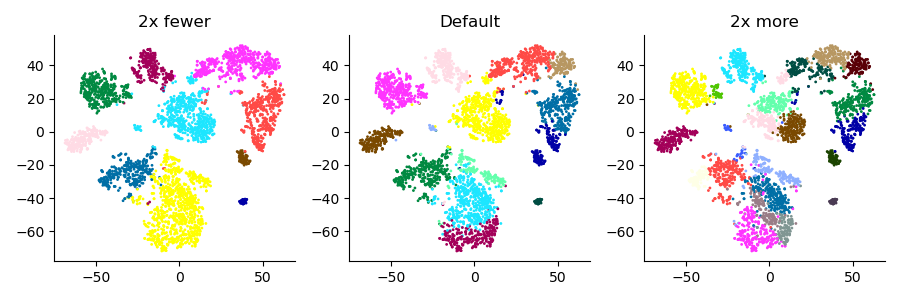

In [92]:
plt.figure(figsize=(9,3))

plt.subplot(131)
plt.scatter(tsne3[:,0], tsne3[:,1], s=1, c=clusterCols[partition2.membership])
plt.title('2x fewer')

plt.subplot(132)
plt.scatter(tsne3[:,0], tsne3[:,1], s=1, c=clusterCols[partition.membership])
plt.title('Default')

plt.subplot(133)
plt.scatter(tsne3[:,0], tsne3[:,1], s=1, c=clusterCols[partition3.membership])
plt.title('2x more')

sns.despine()
plt.tight_layout()